In [173]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

import matplotlib.pyplot as plt

In [174]:
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots

# Understand how the B_t changes in the most performant head

As I am now worried that all the Aw methods are mainly random and it isnt acctually choosing the best head. I am sure that this is due to set_loss being ineffective as it is an ineffective proxy. Thinking back to the DtACI method, it chooses which gamma to uses depending on the distance from alpha_t to B_t which is the best value at each point.

Well this doesnt make sense as you do not tune alpha. So there is nothing to compare.

Main Questions which I want answering:
- Do the most performant heads have the closest to the optimal B_t?

## Getting the Stock Data

In [175]:
def get_stock_data(start_index, end_index):
    # Open txt file containg ticker names
    with open(r'C:\Users\tobyw\Documents\ChrisPython\ConformalProject\scripts\snptickers.txt', 'r') as f:
        all_tickers = f.read().splitlines()
        all_tickers.sort()
    
    stock_tickers = all_tickers[start_index:end_index]

    tickers = yq.Ticker(stock_tickers)
    all_price_data = tickers.history(period='5y', interval='1d')
    price_df = all_price_data[['close']].copy()

    stock_data_tuples = []

    # Some tickers in the list are incorrect or not trading so need 

    for ticker_symbol in price_df.index.get_level_values(0).unique():
        # Getting the volatilty data for each ticker
        ticker_price_data = price_df.loc[ticker_symbol]
        ticker_close = ticker_price_data['close'].to_numpy()

        # As when creating the volaility there is an intial NaN value, I will remove this.
        ticker_close = ticker_close[1:]

        # Appending it to the stock_data_tuples list, the last volatilty is used as the prediciton for the next.
        stock_data_tuples.append((ticker_close[:-1], ticker_close[1:]))
    

    return stock_data_tuples

In [176]:
stock_data = get_stock_data(0, 10)

## Adapted AwACI code.

In [177]:
class B_t_AwACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
         val = (optimal_set - given_set) 
         if val < 0:
              return (self.coverage_target) * (-1* val)
         else:
              return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        all_head_radii = []
        all_interval_weights = []


        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.array([1 for _ in range(len(interval_candidates))])
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
            
            # Create the mass distribution for each head
            Wt = interval_weights.sum()
            interval_probabilites = interval_weights/Wt
        
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            chosen_set = random.choices(head_sets, weights=interval_probabilites, k=1)[0] # Using random module as numpy can not deal with tuples.
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)
            err_t_list.append(err_true)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything.
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2

            all_head_radii.append(head_set_radius)

            optimal_radius_list.append(optimal_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) # Quite redundant
            
            head_set_radius = np.array(head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * Set_loss(optimal_set_radius, head_set_radius)) # log space

            # culmative loss may be better.

            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW) # mean
            interval_weights = final_weights

            all_interval_weights.append(interval_weights)

            # Incrementing the i-count
            i_count+=1

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }


In [178]:
trial = stock_data[1]
ACP = B_t_AwACI(coverage_target=0.1)

In [236]:
result = ACP.AwACI(trial, nu_sigma=(10**-3, 0.6))

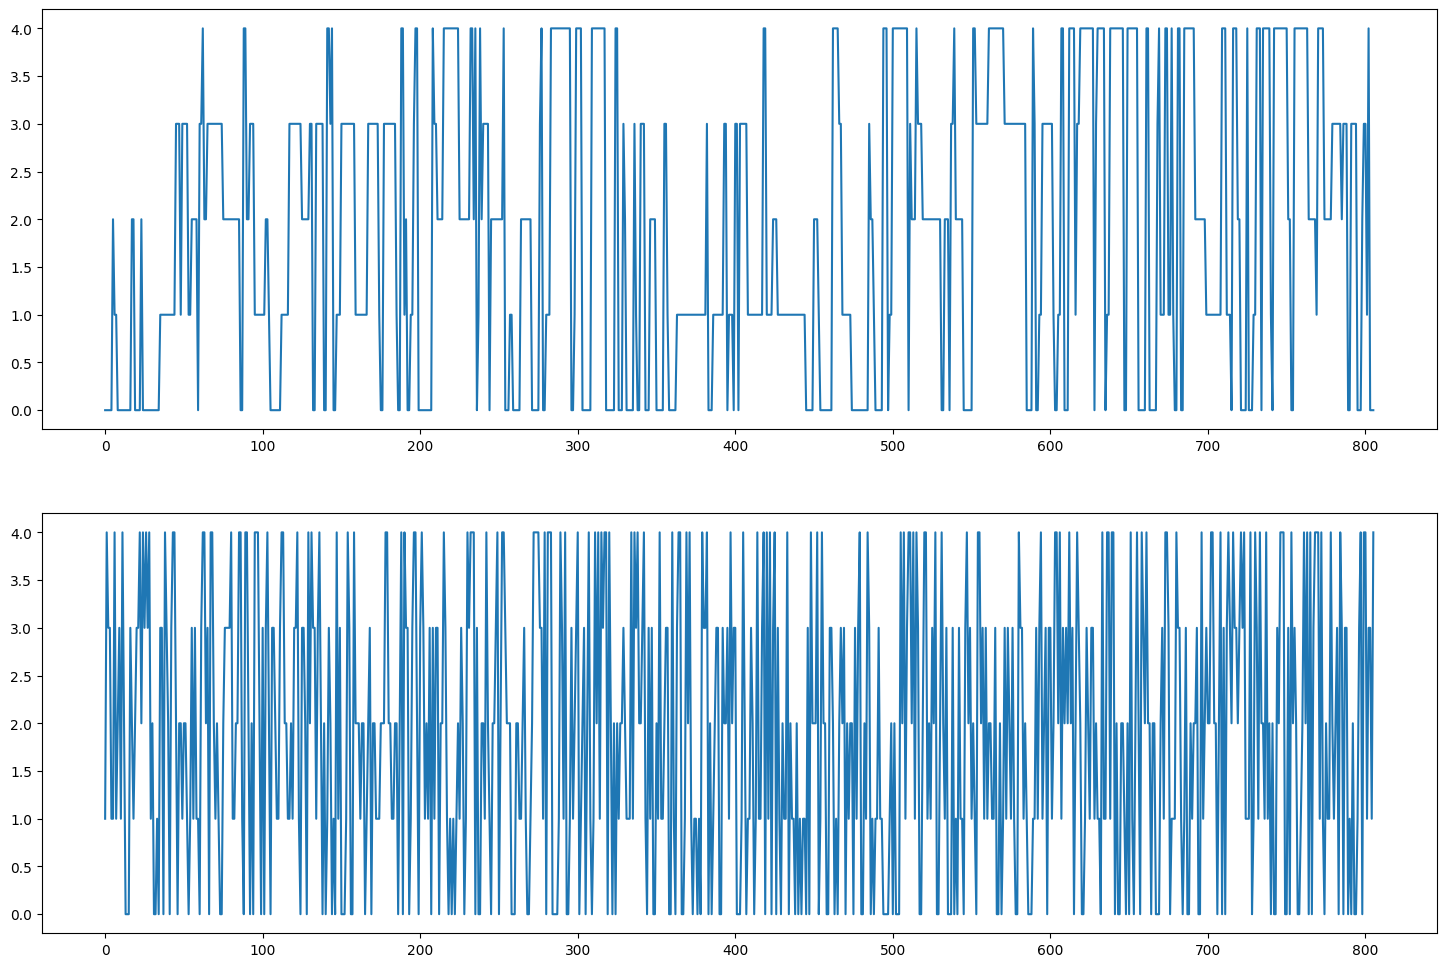

In [237]:
# get the position of the min head in the all_head_radii list
min_index = [np.argmin(x) for x in result['all_head_radii']]
max_index = [np.argmax(x) for x in result['all_weights']]

fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].plot(max_index)
ax[1].plot(result['chosen_interval_index'])
plt.show()

- This clearly shows that AwACI fails to choose the set with the minimum width. The set with the minimum width is not always the best set to choose.
- We can observe that the argmin does not appear to be random. This is a good sign as it may mean that you can get a model to choose better.


In [238]:
max_weight = [np.argmax(x) for x in result['all_weights']]

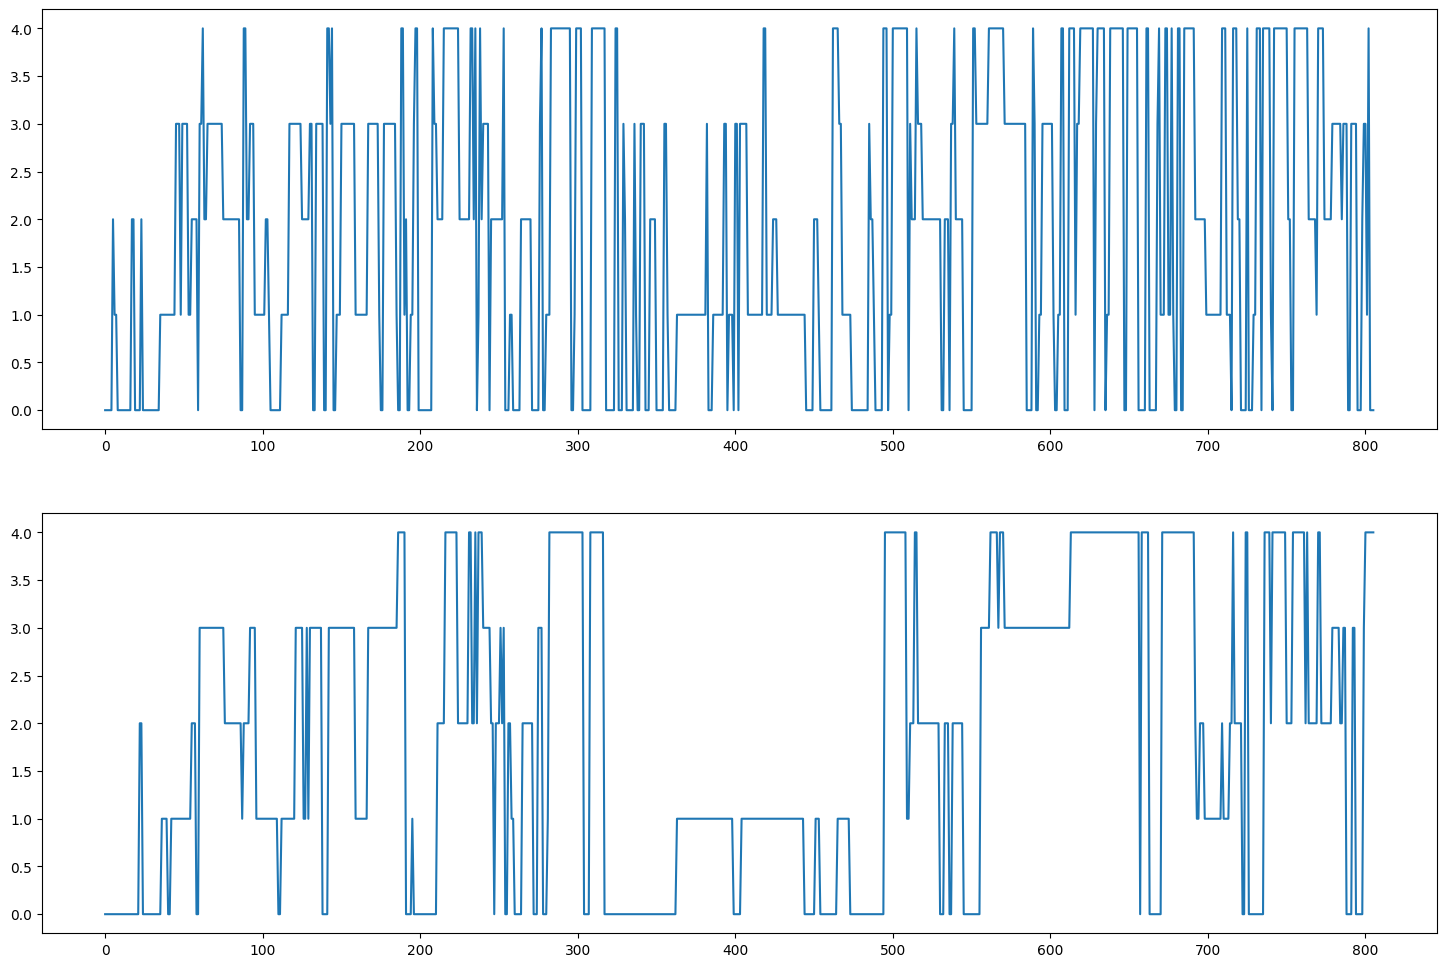

In [239]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].plot(max_weight)
ax[1].plot(min_index)
plt.show()

So the max weight doesnt seem to be a terrible approximation for the min set, which again we are not sure is the best choice, however the acctual choice doesnt not seem to reflect the lowest weight at all

In [240]:
# Lets make a version which doesnt take a random choice it simply chooses the one with the largest weight.

In [241]:
class Largest_Weight_AwACI(AdaptiveCP):
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        all_head_radii = []
        all_interval_weights = []


        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.array([1 for _ in range(len(interval_candidates))])
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
            
            # Create the mass distribution for each head
            Wt = interval_weights.sum()
            interval_probabilites = interval_weights/Wt
        
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here


            # We will choose the set that has the largest weight.
            chosen_set = head_sets[np.argmax(interval_weights)]

            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

            # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)
            err_t_list.append(err_true)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything.
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2

            all_head_radii.append(head_set_radius)

            optimal_radius_list.append(optimal_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) # Quite redundant
            
            head_set_radius = np.array(head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * Set_loss(optimal_set_radius, head_set_radius)) 
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            interval_weights = final_weights

            all_interval_weights.append(interval_weights)

            # Incrementing the i-count
            i_count+=1

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }
    
    

In [242]:
LW_ACP = Largest_Weight_AwACI(0.1)
MW_result = LW_ACP.AwACI(trial)

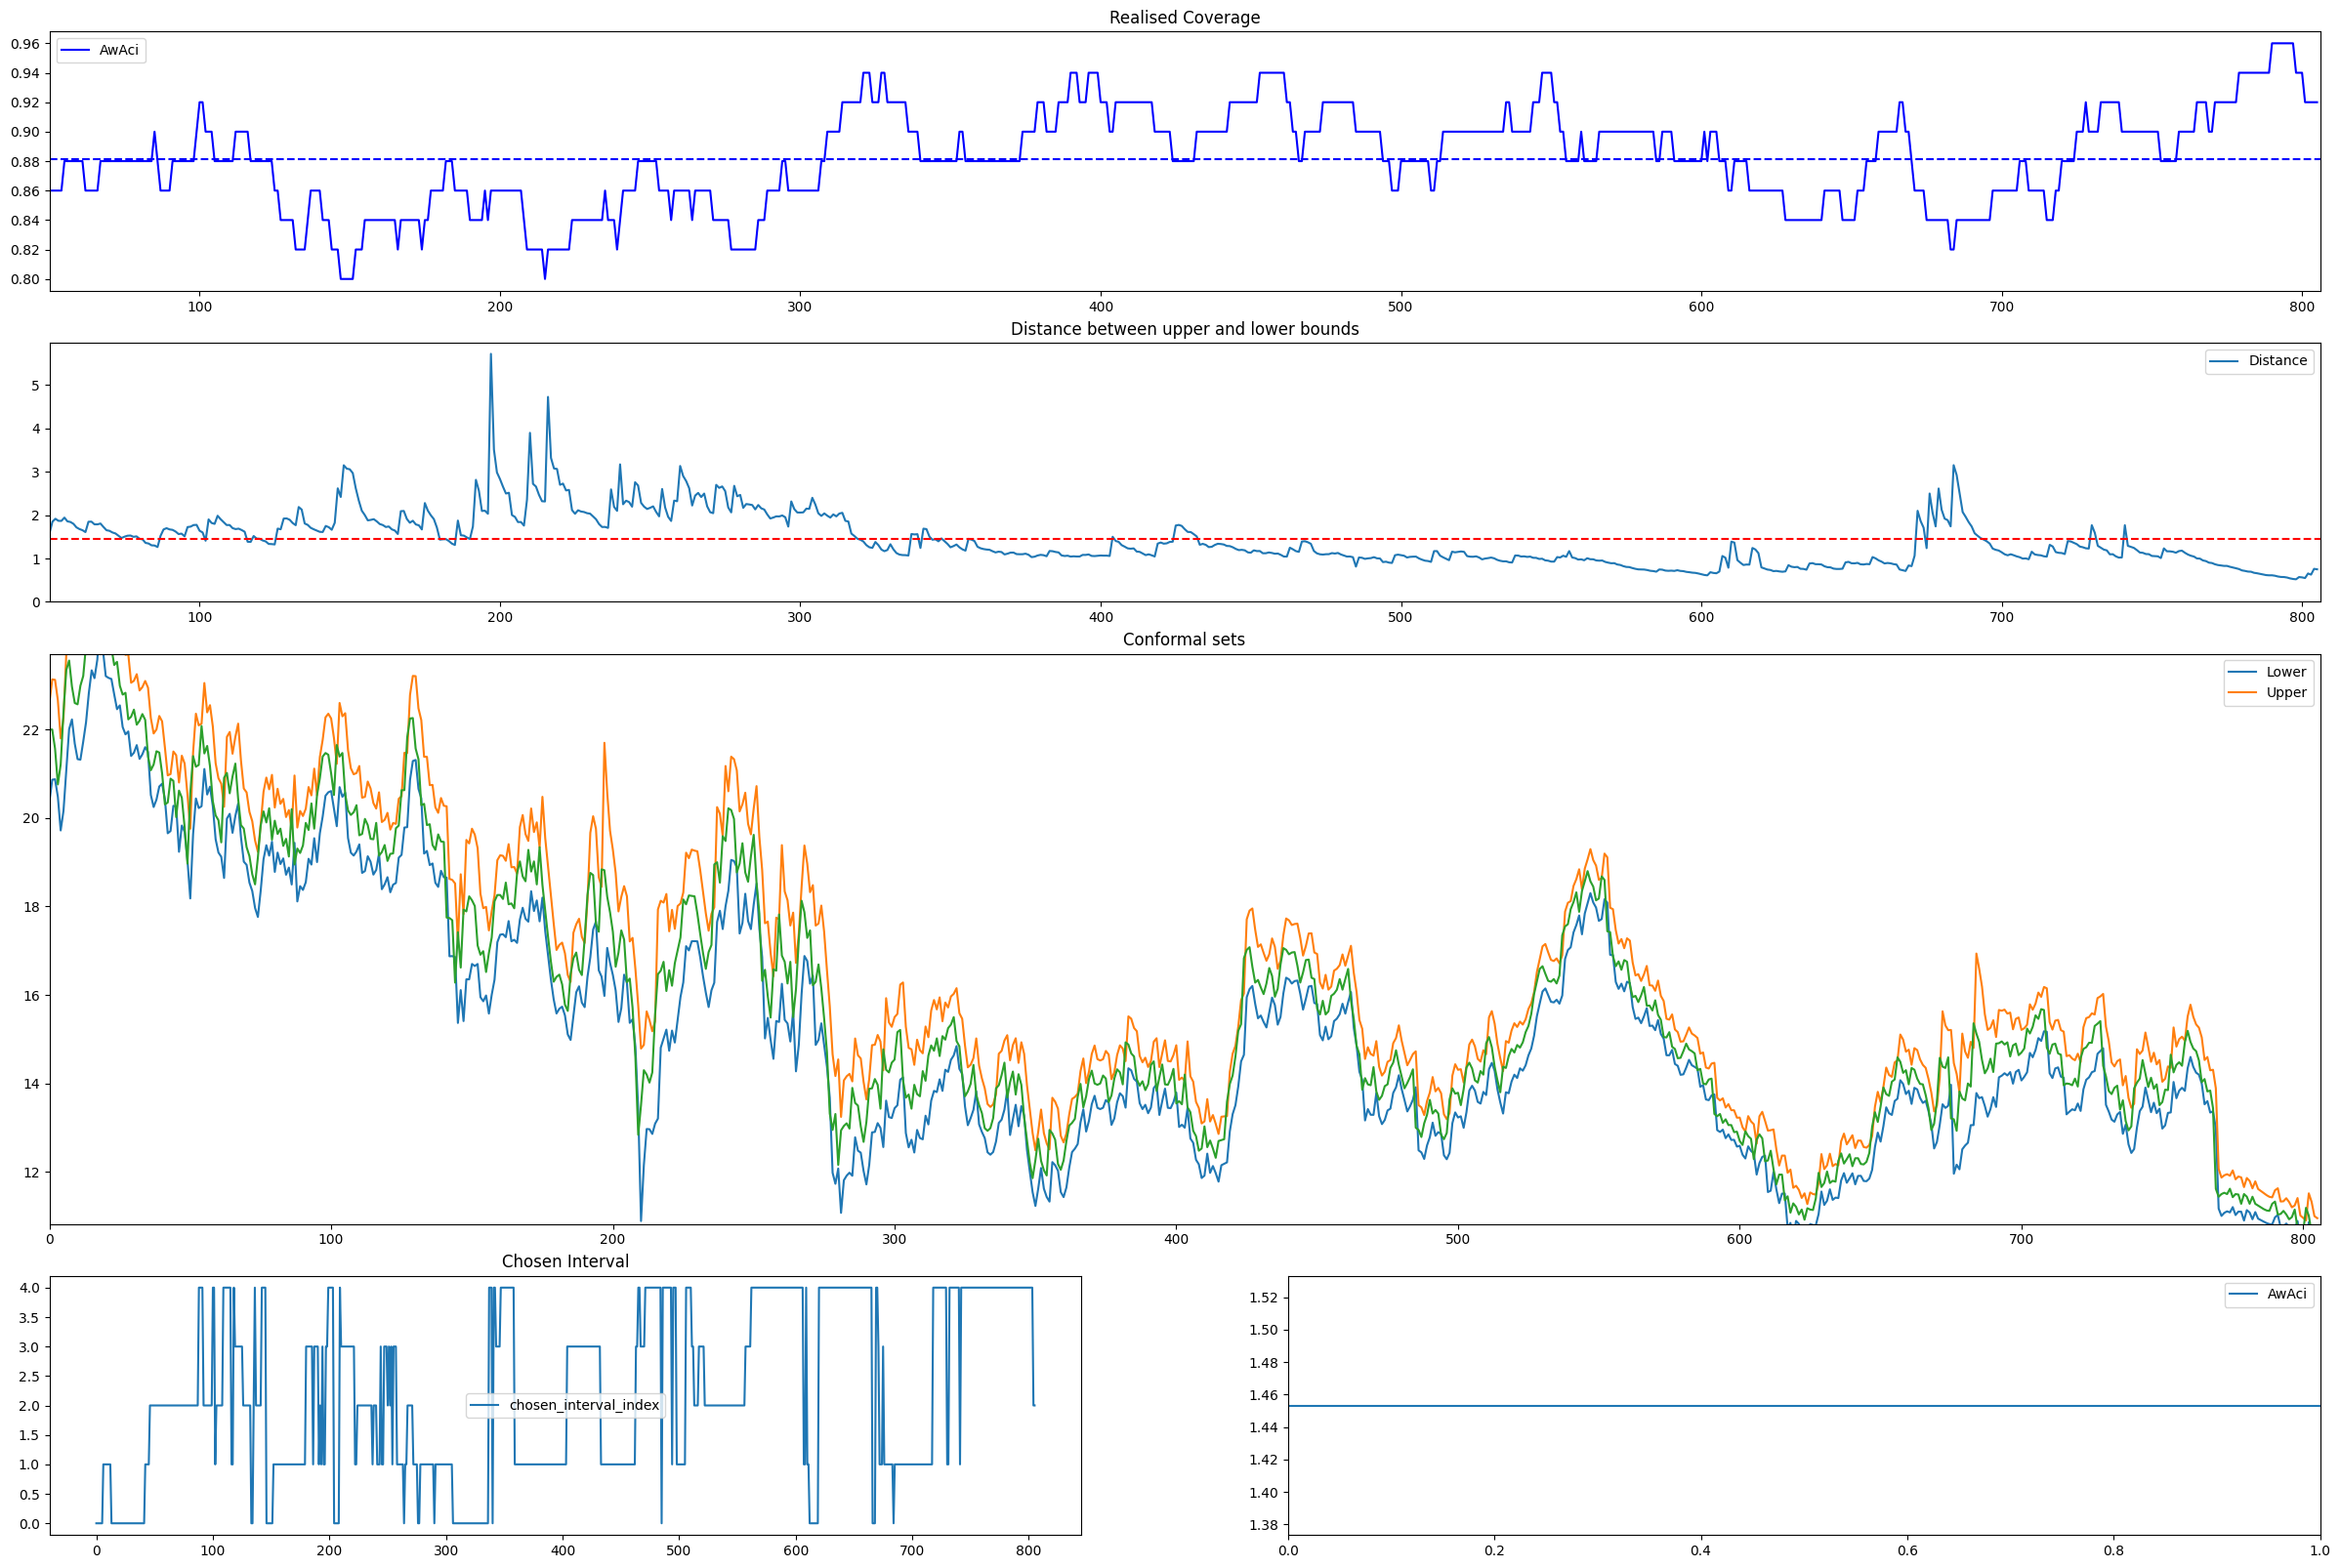

In [243]:
ACP_plots.AwDT_plot(MW_result, trial)

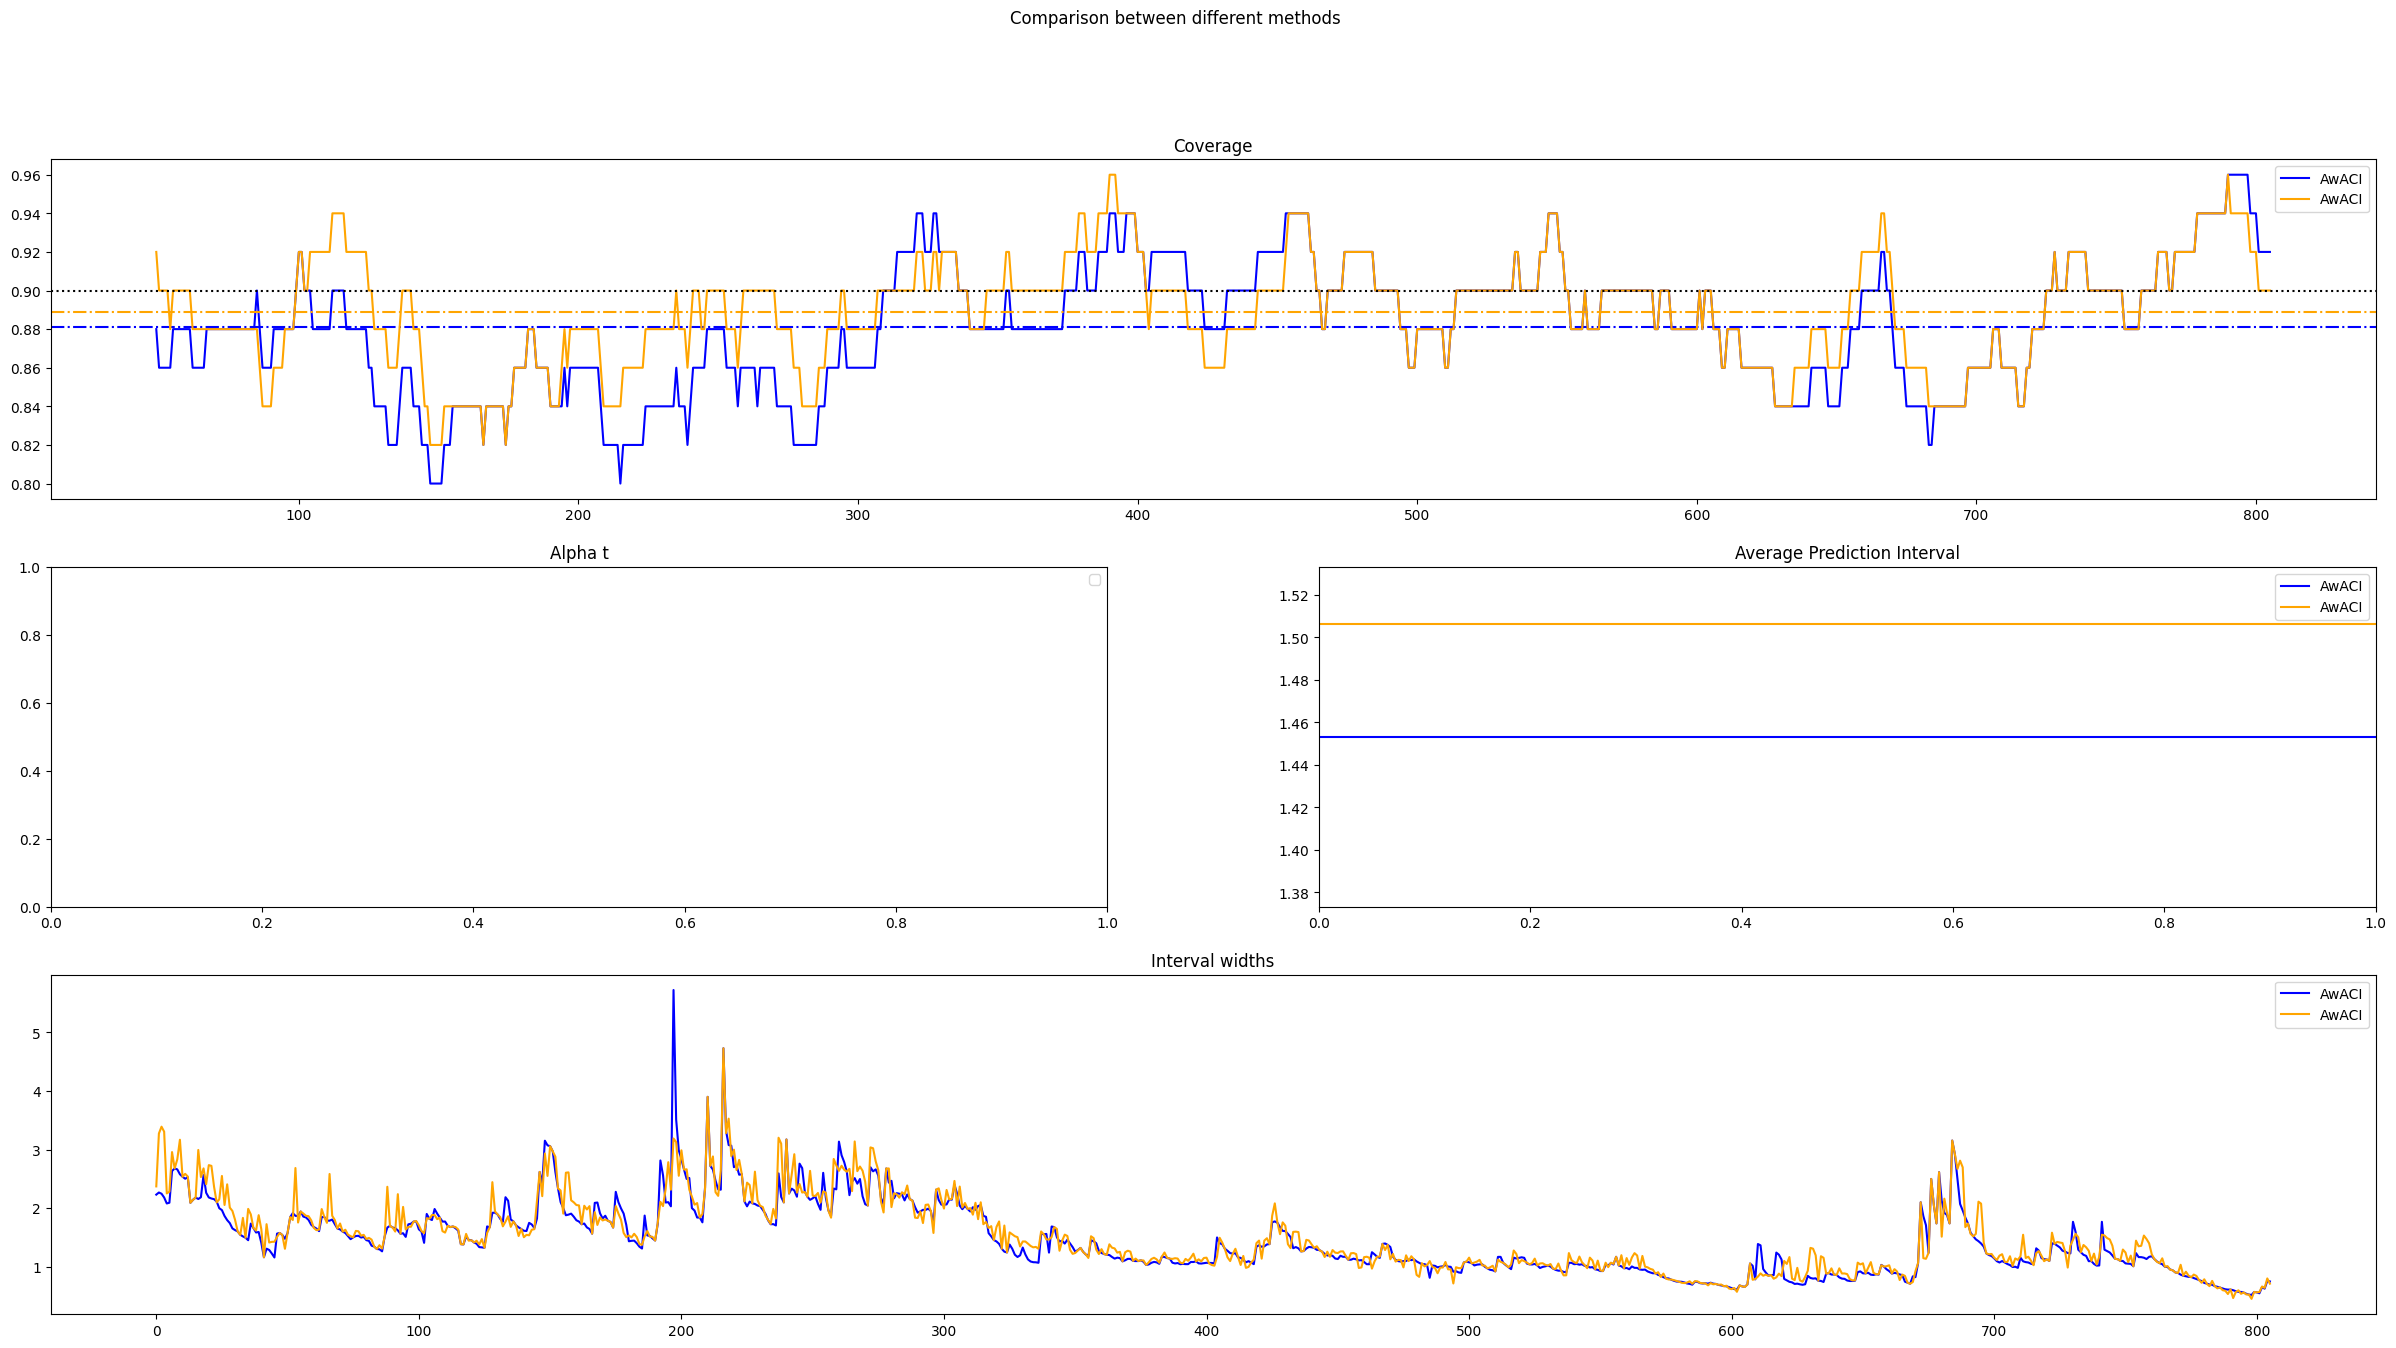

In [244]:
ACP_plots.compare_many([MW_result, result], (30,15))

So choosing the max_weight seems to be potentialy better although it isnt converging to 0.9.

This begs the question as to wh the max weight performs significantly differnt to the normal method. Should investigate the the absolute difference between the max and minimum weight.

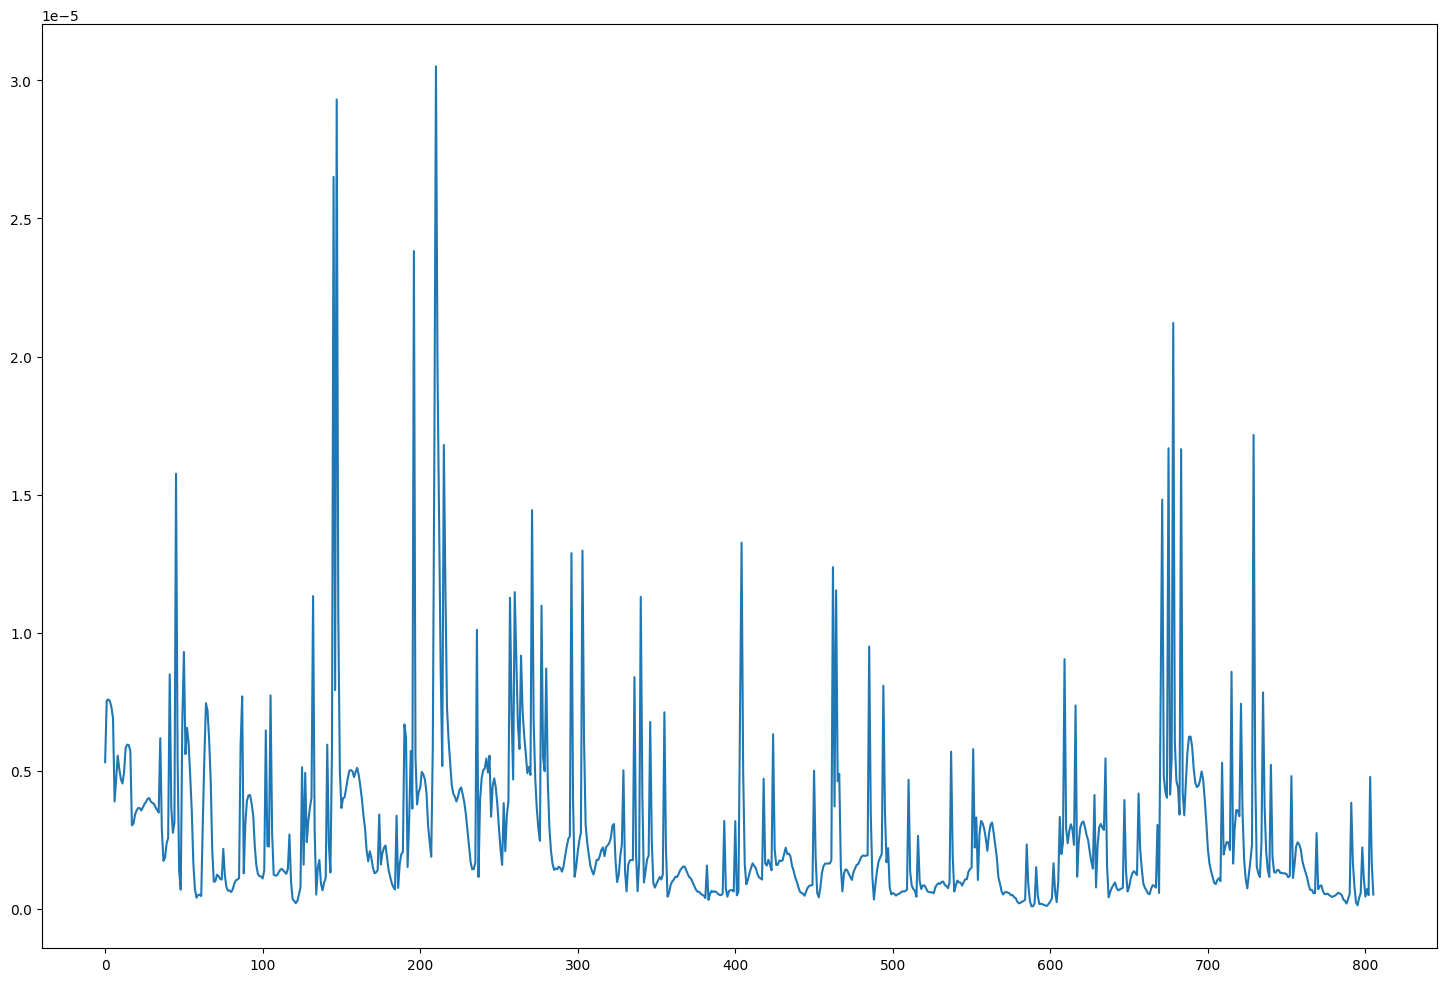

In [245]:
# Will be using result.

all_weights = result['all_weights']

abs_differnce = [(max(x) - min(x))/sum(x) for x in all_weights]

fig, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.plot(abs_differnce)
plt.show()

As expected the change is tiny, which would explain why it is outputing random.

Possible explanation:
- To avoid the weights blowing up need to make mu extra small, but this likley is just counteracting the reweighting.
    - So Need to find a way to keep the weights small but still reweight

In [246]:
class changed_set_loss(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set) / optimal_set
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * 1/(val-1)
         
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        all_head_radii = []
        all_interval_weights = []


        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.array([1 for _ in range(len(interval_candidates))])
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
            
            # Create the mass distribution for each head
            Wt = interval_weights.sum()
            interval_probabilites = interval_weights/Wt
        
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            try:
                chosen_set = random.choices(head_sets, weights=interval_probabilites, k=1)[0] # Using random module as numpy can not deal with tuples
            except ValueError:
                 print(i_count - start_point, interval_probabilites)
                 print(all_interval_weights[-10:])
                 raise ValueError

            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

            # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)
            err_t_list.append(err_true)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything.
      
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2

            all_head_radii.append(head_set_radius)

            optimal_radius_list.append(optimal_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) # Quite redundant
            
            head_set_radius = np.array(head_set_radius)


            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * Set_loss(optimal_set_radius, head_set_radius)) 
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            interval_weights = final_weights

            all_interval_weights.append(interval_weights)

            # Incrementing the i-count
            i_count+=1

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }

In [247]:
NS_ACP = changed_set_loss(0.1)
NS_result = NS_ACP.AwACI(stock_data[1], nu_sigma=(0.1, 0.15))

In [248]:
interval_weights = np.array([0.99987803, 0.99986495, 0.99980588, 0.99975426, 0.99978243])

Wt = interval_weights.sum()
interval_probabilites = interval_weights/Wt

print(interval_probabilites)

Wt = interval_weights.sum()
interval_probabilites = interval_weights/Wt

print(interval_probabilites)

[0.20001219 0.20000957 0.19999775 0.19998743 0.19999306]
[0.20001219 0.20000957 0.19999775 0.19998743 0.19999306]


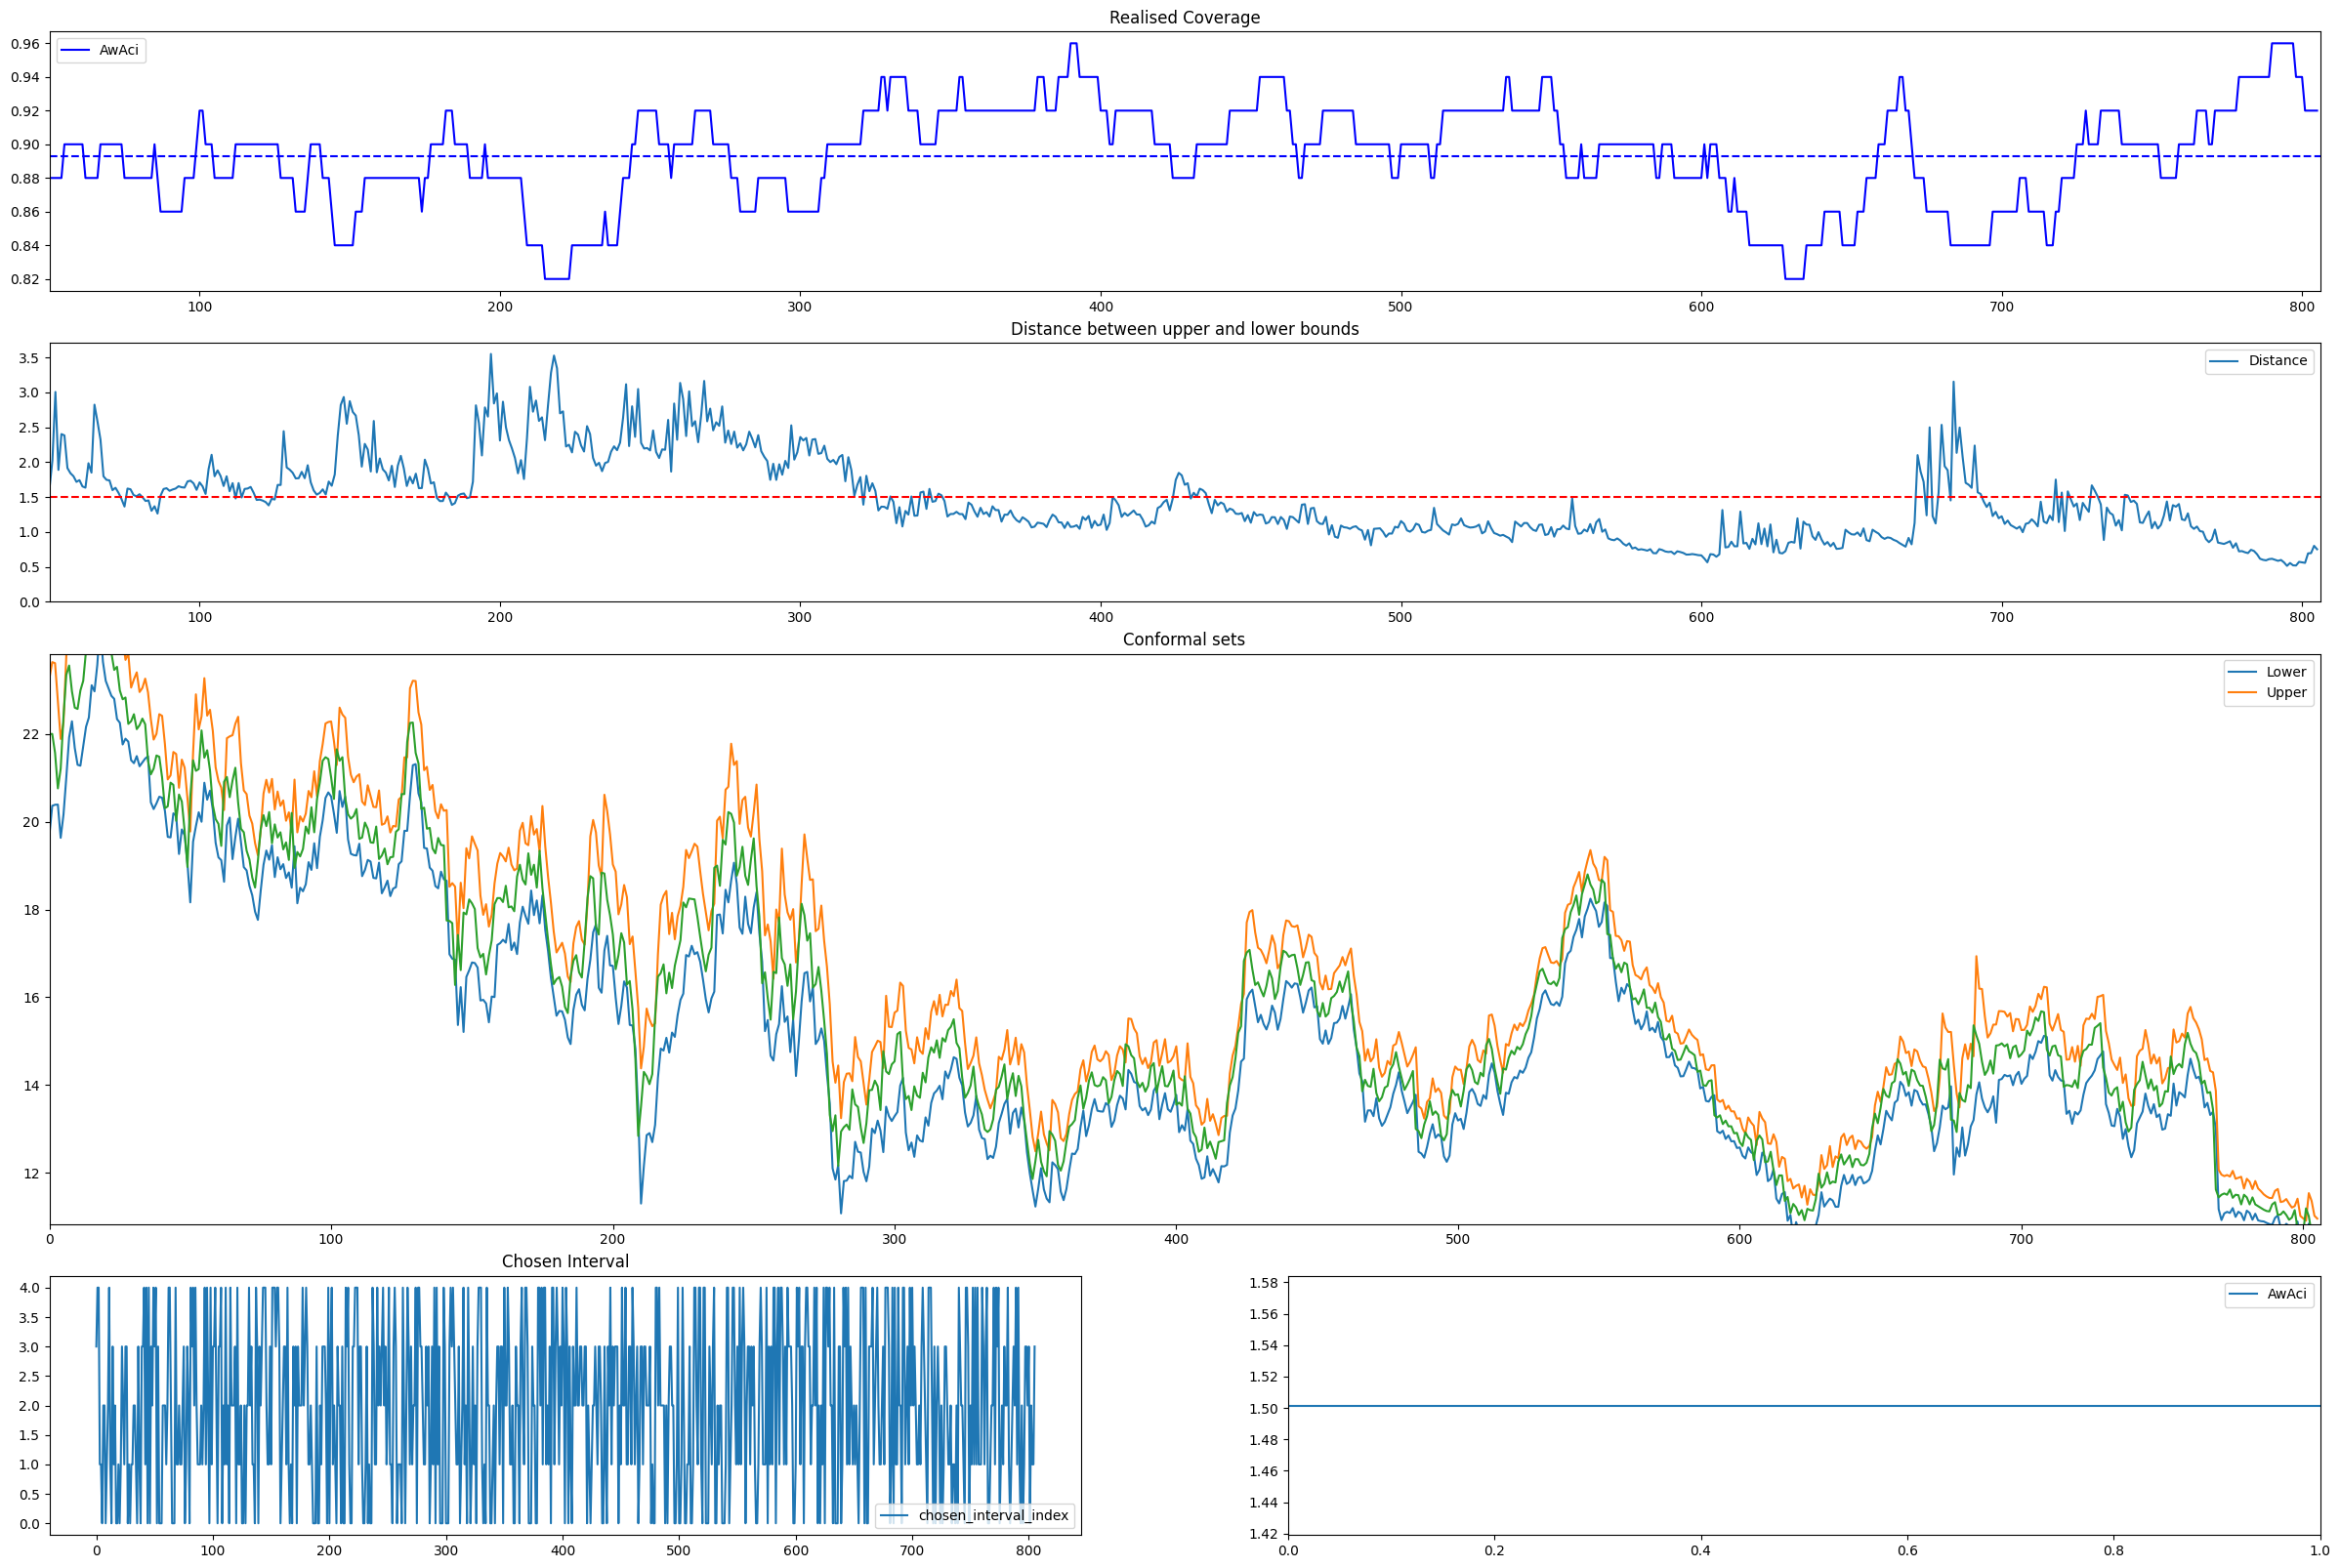

In [249]:
ACP_plots.AwDT_plot(NS_result, trial)

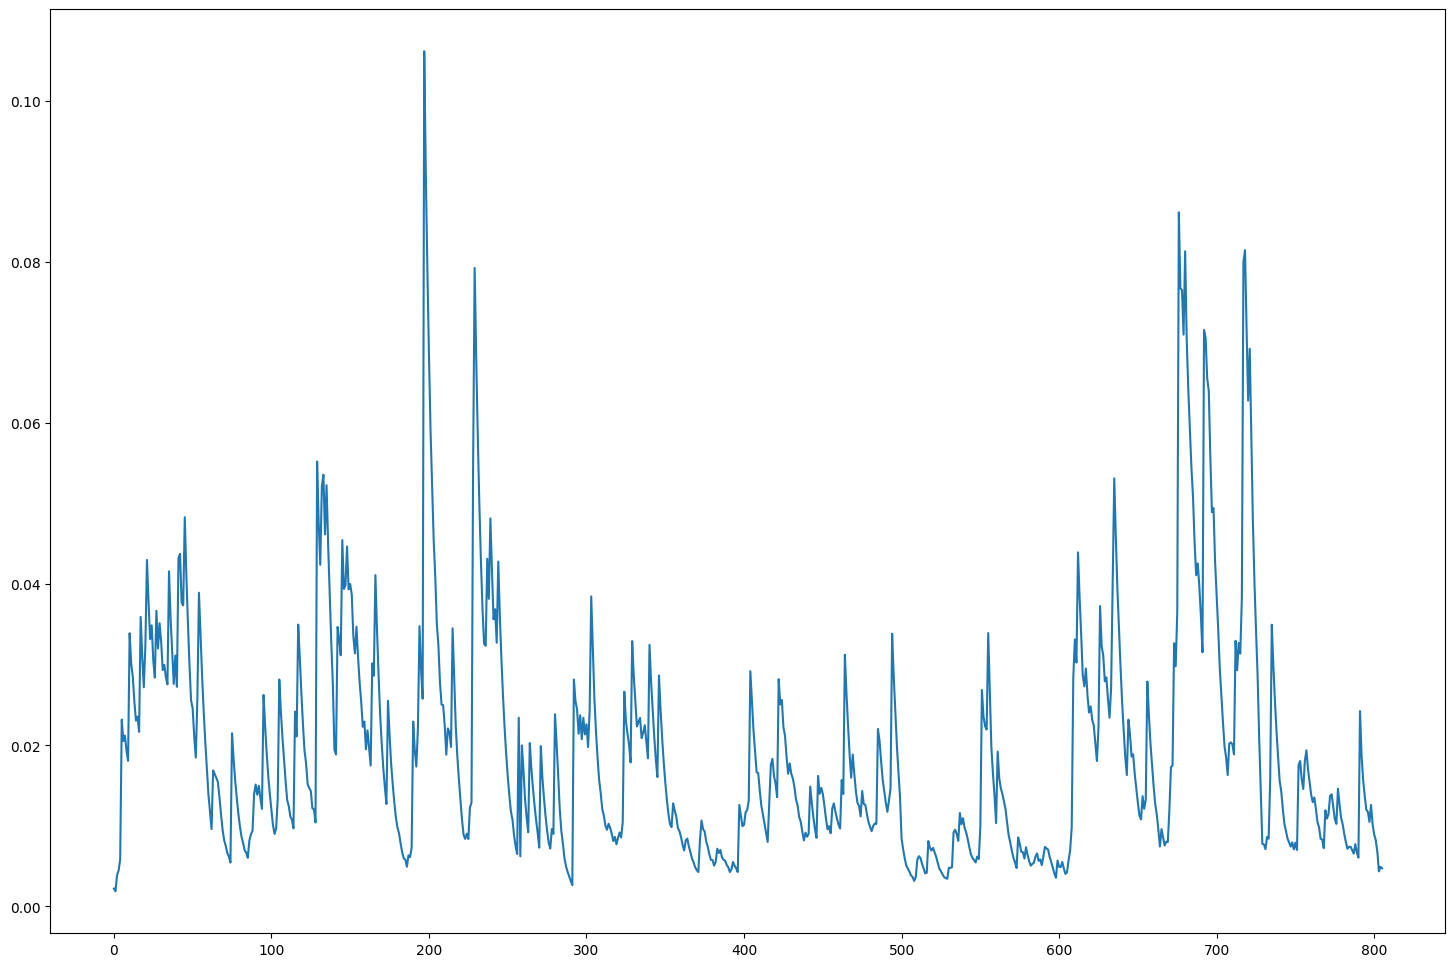

In [250]:
ns_all_weights = NS_result['all_weights']

abs_differnce = [(max(x) - min(x))/sum(x) for x in ns_all_weights]

fig, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.plot(abs_differnce)
plt.show()

In [251]:
class changed_optimal_max(Largest_Weight_AwACI):
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set) / optimal_set
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val
        


    

In [252]:
o_ACP = changed_optimal_max(0.1)
o_result = o_ACP.AwACI(trial, nu_sigma=(5, 0.15))

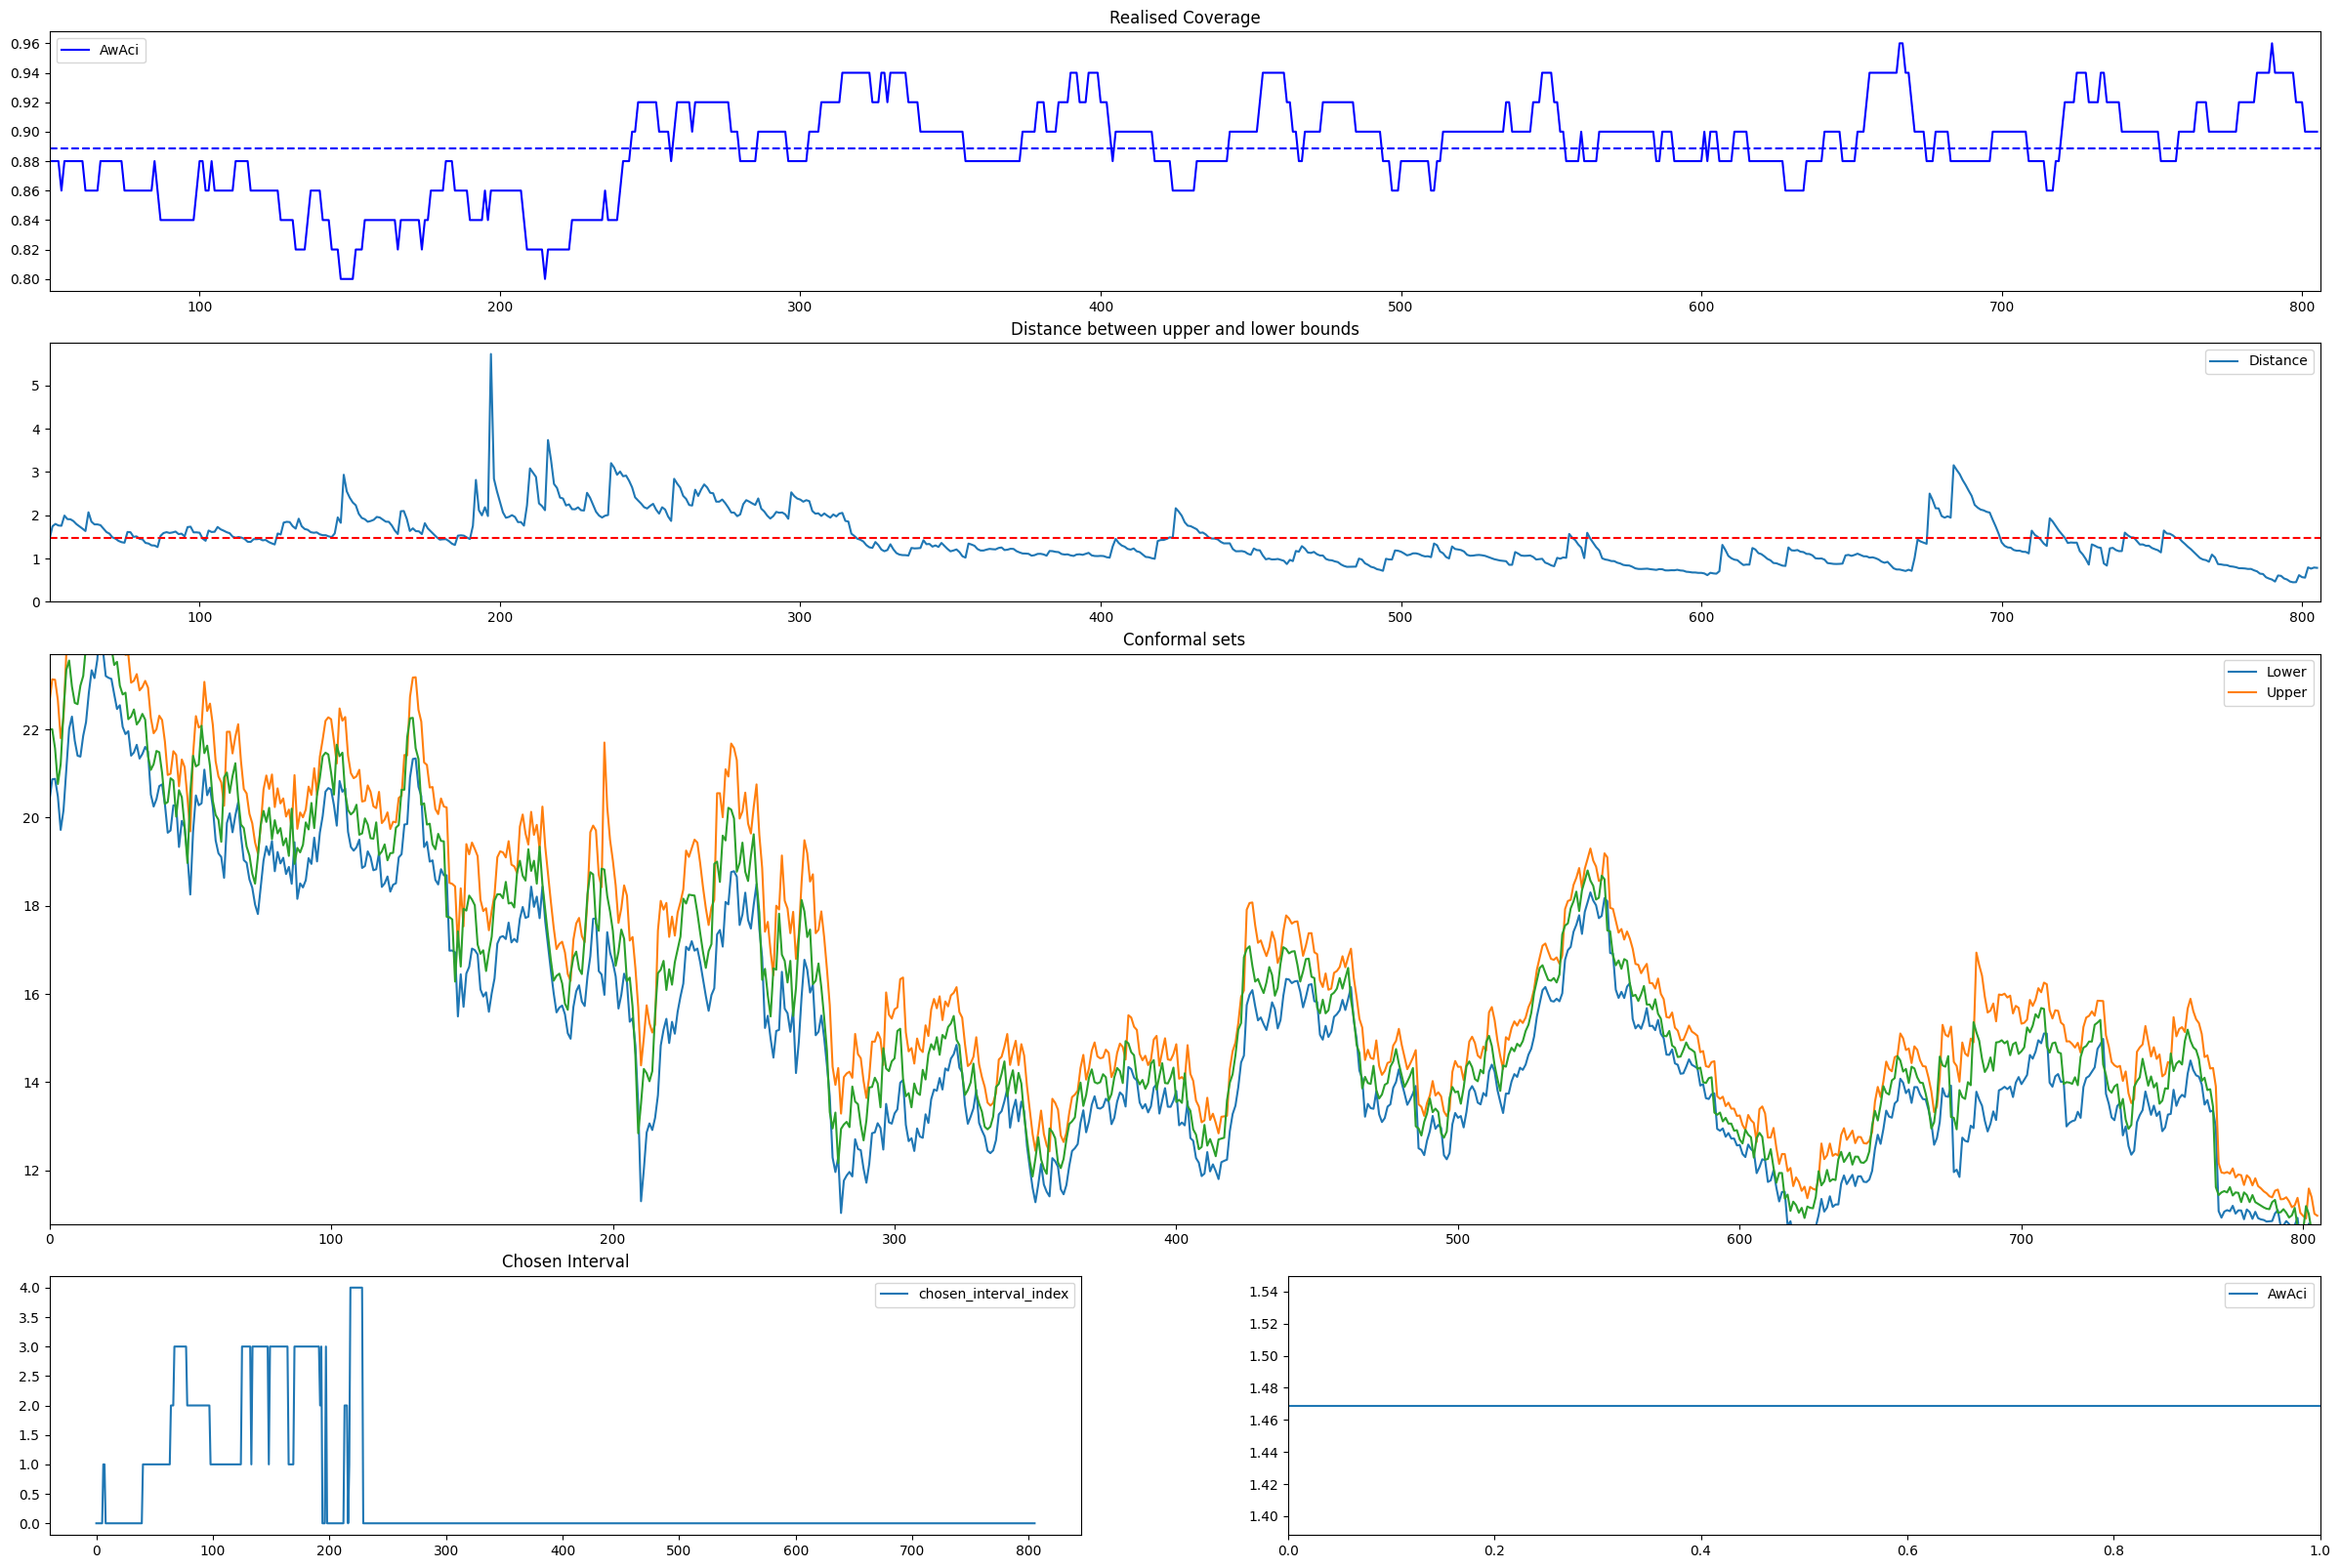

In [253]:
ACP_plots.AwDT_plot(o_result, trial)

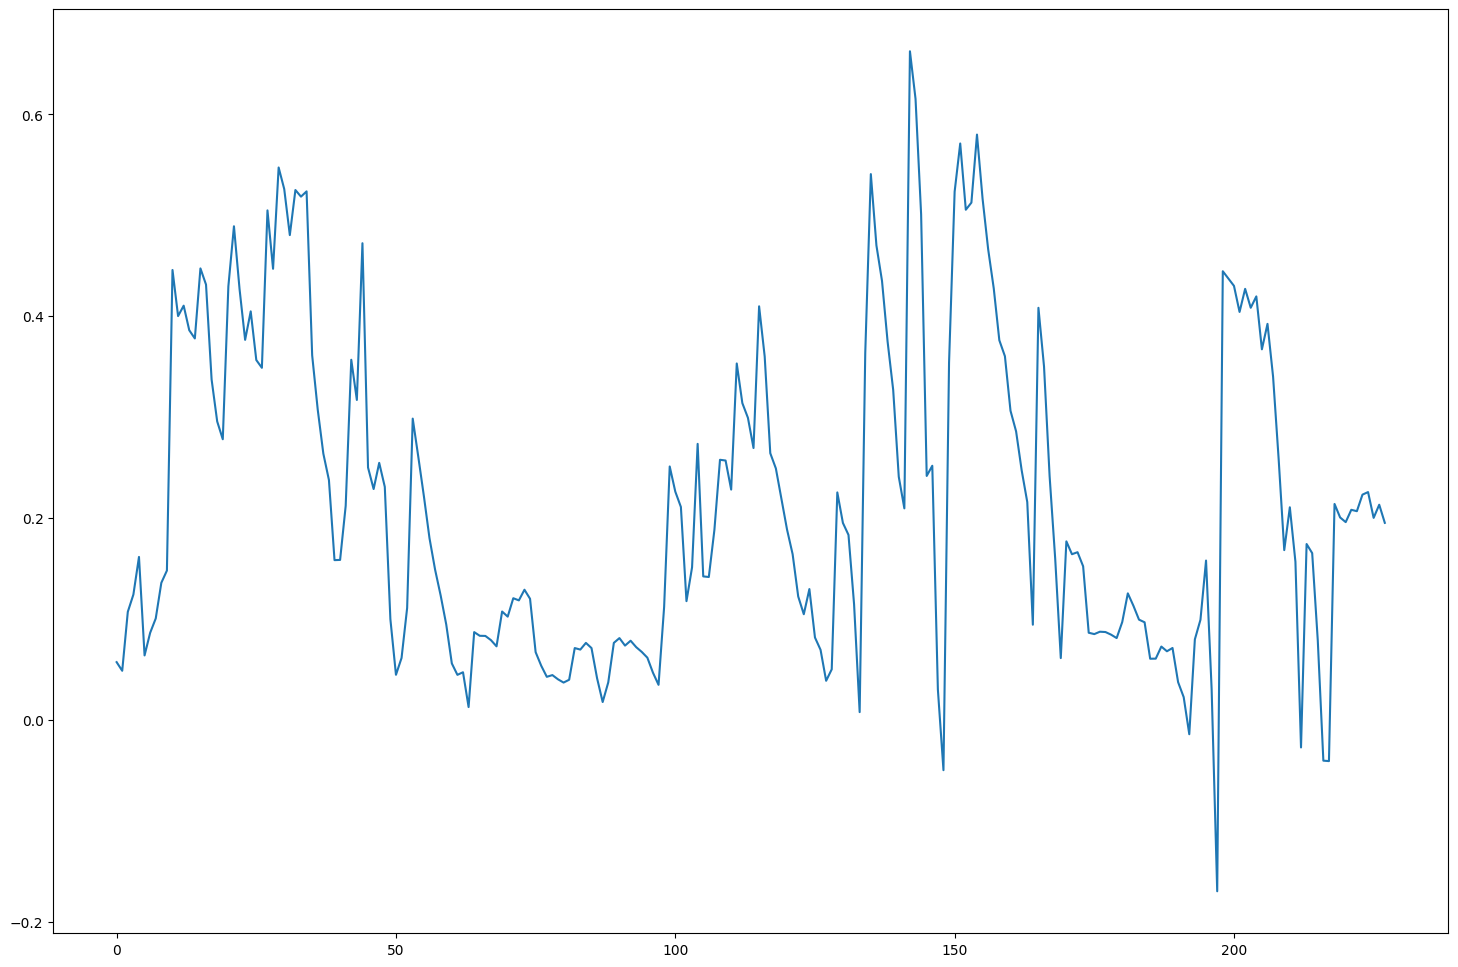

In [254]:
o_all_weights = o_result['all_weights']
chosen_index = o_result['chosen_interval_index']


# relative Difference between chosen and average weight.
abs_differnce = [(x[i] - (sum(x)/len(x)))/sum(x) for i, x in zip(chosen_index, o_all_weights)]

fig, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.plot(abs_differnce)
plt.show()

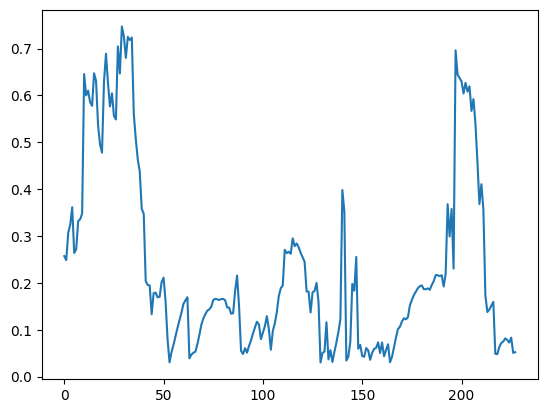

In [255]:
f = [x[0]/sum(x) for x in o_all_weights]
plt.plot(f)
plt.show()

Consider if the optimal value is less than the chosen that means covered
if optimal value is greater than chosen means not covered.

We want to be covered 1 - alpha percent of the time so we should penalise by alpha. hence we should penalise less by alpha

The current set loss doesnt seem to result in a trend too often.

# Investigate how the head with the lowest set loss changes over time

In [256]:
class Best_Set_loss(changed_set_loss):
    
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        all_head_radii = []
        all_interval_weights = []
        all_set_loss = []


        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.array([1 for _ in range(len(interval_candidates))])
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
            
            # Create the mass distribution for each head
            Wt = interval_weights.sum()
            interval_probabilites = interval_weights/Wt
        
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            chosen_set = random.choices(head_sets, weights=interval_probabilites, k=1)[0] # Using random module as numpy can not deal with tuples.
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

            # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)
            err_t_list.append(err_true)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything.
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2

            all_head_radii.append(head_set_radius)

            optimal_radius_list.append(optimal_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) # Quite redundant
            
            head_set_radius = np.array(head_set_radius)

            set_loss = Set_loss(optimal_set_radius, head_set_radius)
            all_set_loss.append(set_loss)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * set_loss) 
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            interval_weights = final_weights

            all_interval_weights.append(interval_weights)

            # Incrementing the i-count
            i_count+=1

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'all_set_loss': all_set_loss,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }


In [257]:
from ConformalMethods import ACP_data

data = ACP_data.random_multi_shift(1, (1300,1301))[0]

Best_Set_loss_ACP = Best_Set_loss(0.1)
BS_result = Best_Set_loss_ACP.AwACI(data, nu_sigma=(10**-5, 0.15))

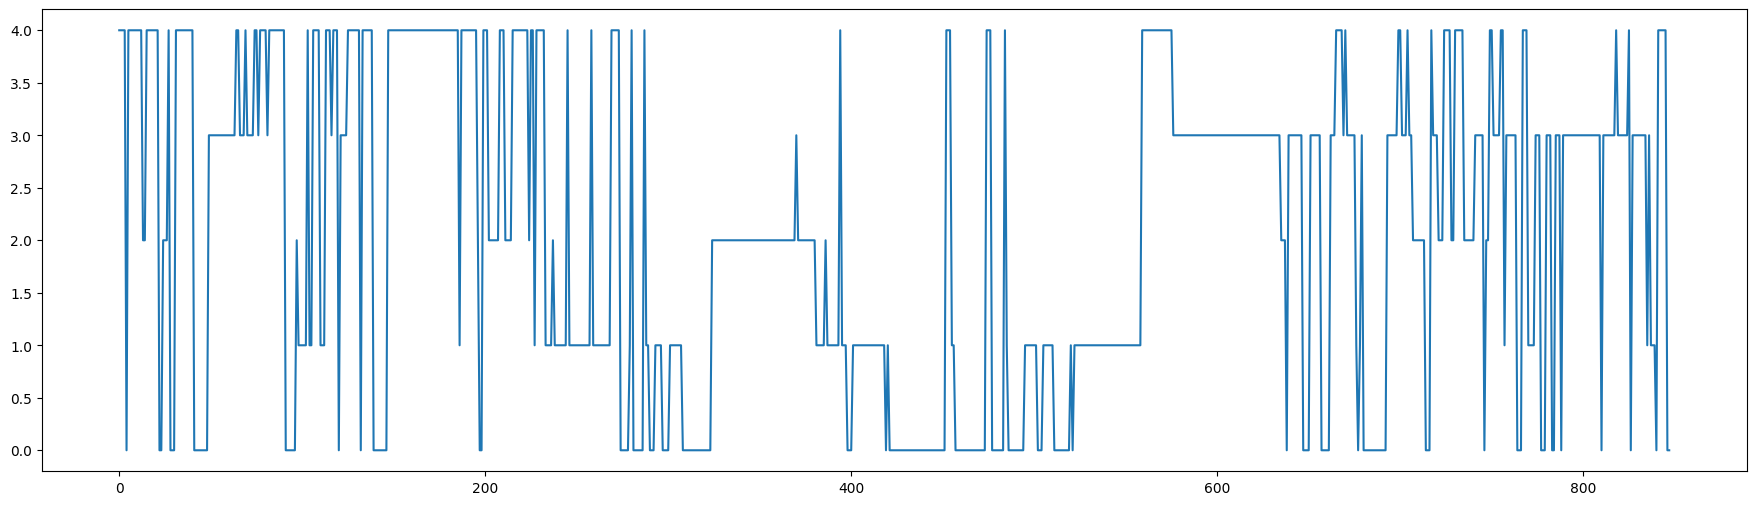

In [258]:
best_head = [np.argmin(x) for x in BS_result['all_set_loss']]
plt.figure(figsize=(22, 6))
plt.plot(best_head)
plt.show()

In [259]:
import numpy as np
from scipy import stats

# Step 1: Define bins for the intervals
bins = np.linspace(0, 4, 5)  # 5 bins for 0-1, 1-2, 2-3, 3-4, 4-5

# Step 2: Count observed frequencies
observed_freq, _ = np.histogram(best_head, bins)
print(observed_freq)

# Step 3: Calculate expected frequencies
expected_freq = np.ones_like(observed_freq) * len(best_head) / len(bins[:-1])
print(expected_freq)

# Step 4: Perform the Chi-Square test
chi2_stat, p_value = stats.chisquare(observed_freq, expected_freq)

# Step 5: Interpret the result
print(f"Chi-Square Statistic: {chi2_stat}, P-value: {p_value}")

[189 158  99 402]
[212. 212. 212. 212.]
Chi-Square Statistic: 246.76415094339623, P-value: 3.2785056349254193e-53


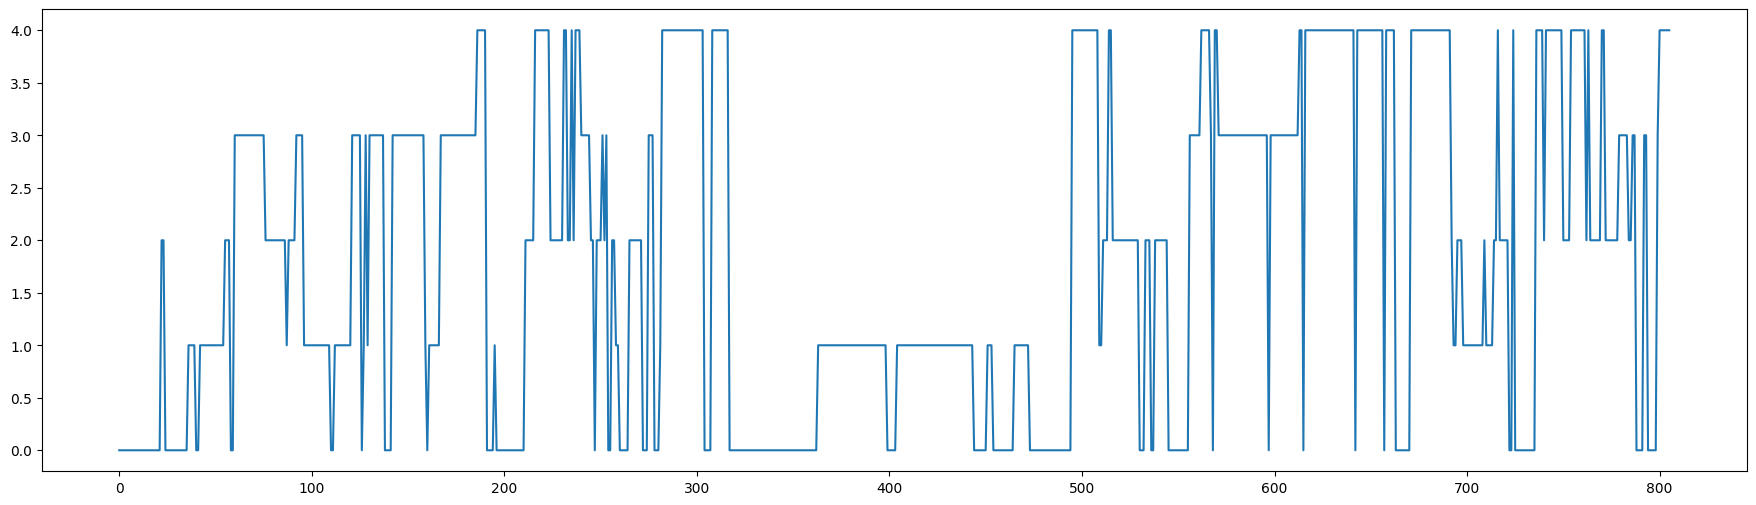

In [260]:
BS_result_stock = Best_Set_loss_ACP.AwACI(stock_data[1], nu_sigma=(10**-5, 0.15))

best_head = [np.argmin(x) for x in BS_result_stock['all_set_loss']]
plt.figure(figsize=(22, 6))
plt.plot(best_head)
plt.show()

In [261]:
import numpy as np
from scipy import stats

# Step 1: Define bins for the intervals
bins = np.linspace(0, 4, 5)  # 5 bins for 0-1, 1-2, 2-3, 3-4, 4-5

# Step 2: Count observed frequencies
observed_freq, _ = np.histogram(best_head, bins)
print(observed_freq)

# Step 3: Calculate expected frequencies
expected_freq = np.ones_like(observed_freq) * len(best_head) / len(bins[:-1])
print(expected_freq)

# Step 4: Perform the Chi-Square test
chi2_stat, p_value = stats.chisquare(observed_freq, expected_freq)

# Step 5: Interpret the result
print(f"Chi-Square Statistic: {chi2_stat}, P-value: {p_value}")

[225 160 110 311]
[201.5 201.5 201.5 201.5]
Chi-Square Statistic: 112.3424317617866, P-value: 3.4369905861371815e-24


There is clearly no trend in that, which woudl explain why the method essentialy outputs random.

Own data generation data it performs better because set_loss has more trend. This makes sense on the stock data as the shifts are less pronounced there is less to learn. So there is less to benefit from the method, this then implies that the data has a large affect on the advantage posed by this method. This would be a good place to stop this document as you have come to an intersting conclusion.

The above conclusion appears to be wrong they both have some levels of trend and are definelty not randomly distributed. Which gives hope to there being a possible method avaliable.

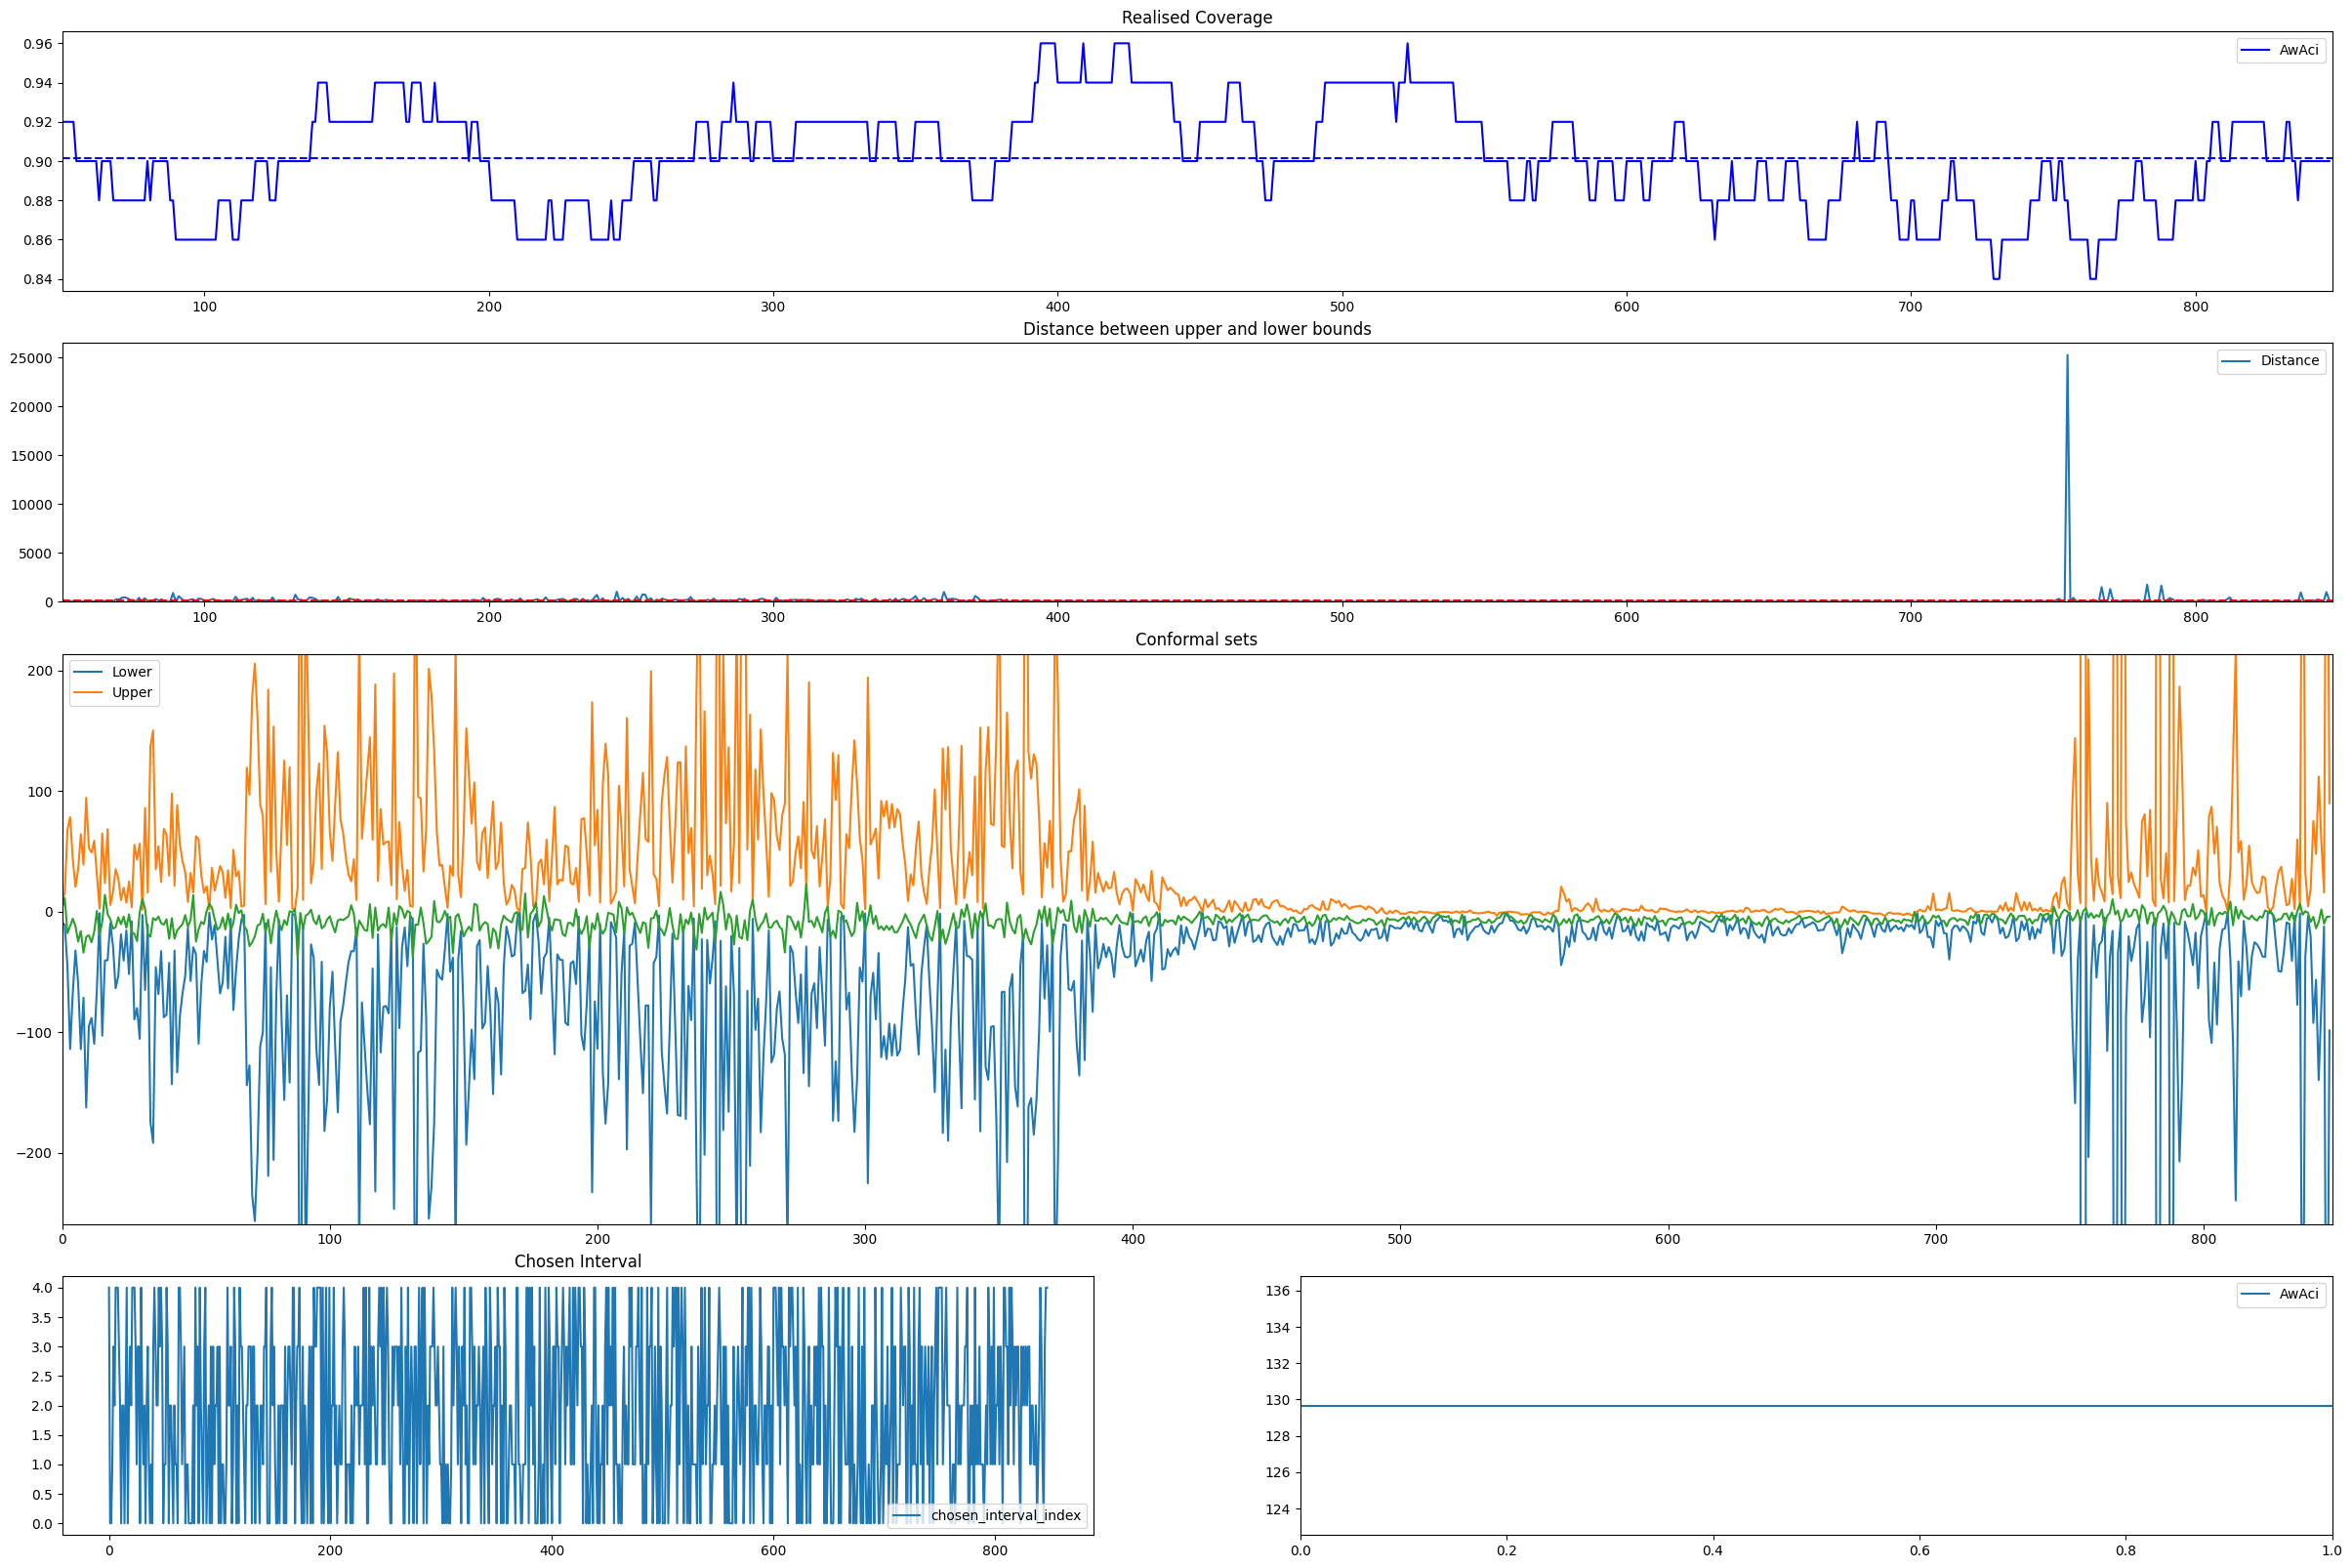

In [262]:
ACP_plots.AwDT_plot(BS_result, data)

In [263]:
import numpy as np
from scipy import stats

# Step 1: Define bins for the intervals
bins = np.linspace(0, 4, 5)  # 5 bins for 0-1, 1-2, 2-3, 3-4, 4-5

# Step 2: Count observed frequencies
observed_freq, _ = np.histogram(BS_result_stock['chosen_interval_index'], bins)
print(observed_freq)

# Step 3: Calculate expected frequencies
expected_freq = np.ones_like(observed_freq) * len(best_head) / len(bins[:-1])
print(expected_freq)

# Step 4: Perform the Chi-Square test
chi2_stat, p_value = stats.chisquare(observed_freq, expected_freq)

# Step 5: Interpret the result
print(f"Chi-Square Statistic: {chi2_stat}, P-value: {p_value}")

[155 184 133 334]
[201.5 201.5 201.5 201.5]
Chi-Square Statistic: 122.6650124069479, P-value: 2.057925224439325e-26


So it doenst seem to be outputing as randomly as I expected to a notebook exploring this.